Rozmiar obrazu (h, w): (599, 800), rozmiar z Pillow (width, height): (800, 599)


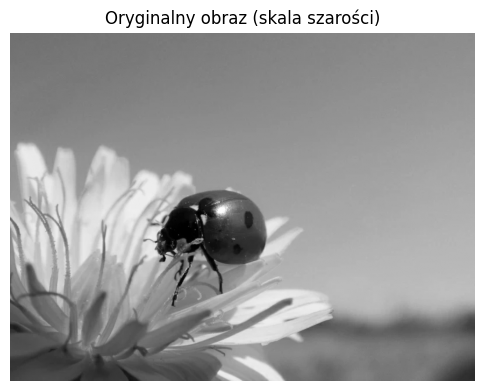

Liczba singularnych wartości: 599
Minimalne k potrzebne by zachować 90% energii: 1 z 599


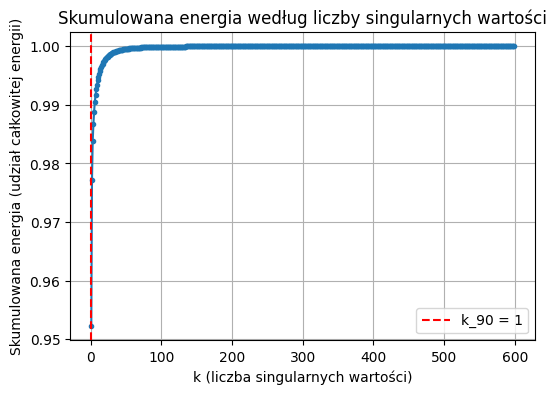

Zapisano rekonstrukcję dla k=1 -> wyniki\recon_k_1.png (rozmiar: (599, 800))
Zapisano rekonstrukcję dla k=5 -> wyniki\recon_k_5.png (rozmiar: (599, 800))
Zapisano rekonstrukcję dla k=20 -> wyniki\recon_k_20.png (rozmiar: (599, 800))
Zapisano rekonstrukcję dla k=50 -> wyniki\recon_k_50.png (rozmiar: (599, 800))
Zapisano rekonstrukcję dla k=100 -> wyniki\recon_k_100.png (rozmiar: (599, 800))
Zapisano rekonstrukcję dla k=200 -> wyniki\recon_k_200.png (rozmiar: (599, 800))


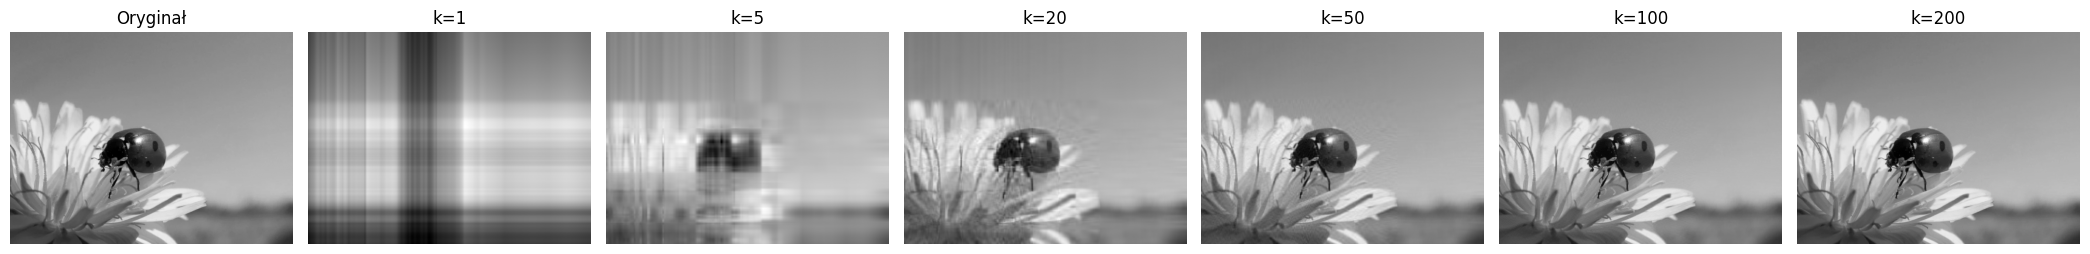

Przybliżony współczynnik kompresji dla k=1: 342.286 (oryginalne piksele / parametry SVD)
Ścieżka do zapisanego pliku rekonstrukcji k_90: wyniki\recon_k_1.png
- wyniki\recon_k_1.png
- wyniki\recon_k_100.png
- wyniki\recon_k_20.png
- wyniki\recon_k_200.png
- wyniki\recon_k_5.png
- wyniki\recon_k_50.png


In [1]:
# Importy i funkcje pomocnicze
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

# Funkcja do wczytania obrazu i konwersji do skali szarości (float)
def load_image_gray(path):
    img = Image.open(path).convert('L')  # 'L' -> grayscale
    arr = np.array(img).astype(float)
    return arr, img.size  # size = (width, height)

# Funkcja do zapisu macierzy jako obrazu uint8
def save_image_from_array(arr, out_path):
    arr_clipped = np.clip(arr, 0, 255).astype(np.uint8)
    Image.fromarray(arr_clipped).save(out_path)

# Funkcja do rekonstrukcji przy użyciu k wartości singularnych
def svd_reconstruct(A, k):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vtk = Vt[:k, :]
    return Uk @ Sk @ Vtk

# Funkcja do obliczenia minimalnego k by zachować energy_ratio (np. 0.9)
def find_k_for_energy(S, energy_ratio=0.9):
    singular_vals_sq = S**2
    total_energy = singular_vals_sq.sum()
    cumulative = np.cumsum(singular_vals_sq)
    k = np.searchsorted(cumulative, energy_ratio * total_energy) + 1
    return k, total_energy, cumulative

# Ścieżka do obrazu
image_path = '1.webp'
out_dir = 'wyniki'
os.makedirs(out_dir, exist_ok=True)

A, size = load_image_gray(image_path)
h, w = A.shape
print(f"Rozmiar obrazu (h, w): {A.shape}, rozmiar z Pillow (width, height): {size}")

# Pokaż oryginalny (grayscale)
plt.figure(figsize=(6,6))
plt.imshow(A, cmap='gray')
plt.title('Oryginalny obraz (skala szarości)')
plt.axis('off')
plt.show()

# Obliczanie SVD (full_matrices=False dla wydajności)
U, S, Vt = np.linalg.svd(A, full_matrices=False)
print('Liczba singularnych wartości:', S.shape[0])

# Znajdź k dla 90% energii
energy_target = 0.90
k_90, total_energy, cumulative = find_k_for_energy(S, energy_ratio=energy_target)
print(f"Minimalne k potrzebne by zachować {energy_target*100:.0f}% energii: {k_90} z {S.shape[0]}")

# Wykres skumulowanej energii
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(S)+1), np.cumsum(S**2) / total_energy, marker='o', markersize=3)
plt.xlabel('k (liczba singularnych wartości)')
plt.ylabel('Skumulowana energia (udział całkowitej energii)')
plt.grid(True)
plt.axvline(k_90, color='r', linestyle='--', label=f'k_90 = {k_90}')
plt.legend()
plt.title('Skumulowana energia według liczby singularnych wartości')
plt.show()

# Wybrane wartości k do demonstracji: małe, k_90, większe (ograniczone do długości S)
k_values = [5, 20, k_90, 50, 100, min(len(S), 200)]
k_values = sorted(list(set([min(int(k), len(S)) for k in k_values])))
recons = {}
for k in k_values:
    rec = svd_reconstruct(A, k)
    recons[k] = rec
    out_path = os.path.join(out_dir, f'recon_k_{k}.png')
    save_image_from_array(rec, out_path)
    print(f"Zapisano rekonstrukcję dla k={k} -> {out_path} (rozmiar: {rec.shape})")

# Pokaż porównanie (ograniczone do max 6 kolumn)
cols = len(recons) + 1
plt.figure(figsize=(3*cols, 4))
plt.subplot(1, cols, 1)
plt.imshow(A, cmap='gray')
plt.title('Oryginał')
plt.axis('off')

i = 2
for k, rec in sorted(recons.items()):
    plt.subplot(1, cols, i)
    plt.imshow(rec, cmap='gray')
    plt.title(f'k={k}')
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.show()

# Obliczanie współczynnika kompresji dla k (przybliżonego)
def compression_ratio(h, w, k):
    original = h * w
    compressed = h*k + k + k*w
    return original / compressed

cr_k90 = compression_ratio(h, w, k_90)
print(f'Przybliżony współczynnik kompresji dla k={k_90}: {cr_k90:.3f} (oryginalne piksele / parametry SVD)')
# Zapisz macierz rekonstrukcji dla k_90 (już powinna być zapisana)
recon_k90_path = os.path.join(out_dir, f'recon_k_{k_90}.png')
print('Ścieżka do zapisanego pliku rekonstrukcji k_90:', recon_k90_path)

# Lista wygenerowanych plików w katalogu wyników
import glob
files = glob.glob(os.path.join(out_dir, '*'))
for f in files:
    print('-', f)
